IMPORTING THE LIBRARIES

In [1]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import time
import torch
import torchvision.models as models

In [2]:
import torch.nn as nn

In [3]:
device = torch.device('cuda')
print(device)

cuda


In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
model= models.vgg19(pretrained=True).to(device)

C:\Users\bhave\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bhave\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
train_images = []
Masks = []

In [7]:
from torchvision import transforms


In [8]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),# Converts the image to a tensor and scales pixel values to [0, 1]
])


In [9]:
masks_transform = transforms.Compose([
    transforms.Lambda(lambda x : x > 0.04),# Converts the image to a tensor and scales pixel values to [0, 1]
])

Data loading

In [10]:
i=0
for dirpath, dirnames, filenames in os.walk(r"D:\Sahaay\obstacle_detection\City_dataset_full-20240728T123354Z-001\City_dataset_full"):
    if dirnames and i==0 :
        i=i+1
        pass

    elif dirnames and i!=0 :
        path = os.path.join(dirpath,"images")
        path_masks= os.path.join(dirpath,"mask")
        items = os.listdir(path)
        masks = os.listdir(path_masks)
        count = 0
        for item in items:
            img = Image.open(os.path.join(path,item))
            train_images.append(transform(img))
            # img = img.resize((256,256))
            # img = np.array(img)/255
            # img_tensor = torch.tensor(img, dtype=torch.float32)
            # train_images.append(img_tensor)


        for mask in masks:
            if count % 3 == 1 :
                msk = os.path.join(path_masks,mask)
                msk = Image.open(msk)
                Masks.append(transform(msk))
                count =count +1
            else :
                count= count +1

In [11]:
print(train_images[0].shape)
print(Masks[0].shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [12]:
# torch.tensor(train_images,dtype=torch.float32) this method is wrong u cant convert a list of tensors to a tensor u need to use stack
X_train = torch.stack(train_images, dim =0)
y_train = torch.stack(Masks,dim=0)

In [13]:
y_train = y_train[:,0,:,:]

In [14]:
X_train.shape

torch.Size([1213, 3, 256, 256])

In [15]:
y_train = masks_transform(y_train).float()

In [16]:
y_train.shape

torch.Size([1213, 256, 256])

In [17]:
y_train.squeeze(dim=1).size()

torch.Size([1213, 256, 256])

Architecture

In [18]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [19]:
class CustomDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        return image, mask


In [20]:
from torch.utils.data import random_split


In [21]:
total_size = len(CustomDataset(X_train,y_train))
train_size = int(0.9 * total_size)  # 90% for training
val_size = total_size - train_size   # The remaining 10% for validation


In [22]:
train_dataset, val_dataset = random_split(CustomDataset(X_train,y_train), [train_size, val_size])

In [23]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= 8 ,shuffle=False)

In [24]:
#listing all the layers
layers = list(model.children())[0]
layers.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [25]:
def conv_block(input_channels,output_channels):
   block = nn.Sequential(
   nn.Conv2d(in_channels=input_channels,out_channels = output_channels,kernel_size=3,stride=1,padding=1),
   nn.ReLU(),
   nn.Conv2d(in_channels=output_channels,out_channels = output_channels,kernel_size=3,stride=1,padding=1),
   nn.ReLU()
   )
   return block

In [26]:
class Concatenate(nn.Module):
    def __init__(self, skip_features):
        super().__init__()
        self.skip_features = skip_features

    def forward(self, x):
        # if x.is_cuda:
        self.skip_features = self.skip_features.to(x.device)
        print(self.skip_features.shape)
        print(x.shape)
        return torch.cat((self.skip_features, x), dim=1)


In [27]:
def decoder_block(input_channels,output_channels):
  block = nn.Sequential(
      nn.ConvTranspose2d(input_channels,output_channels,kernel_size=2,stride=2,padding=0),
  )
  return block

In [28]:
class Decoder_block(nn.Module):

  def __init__(self,input_channels,output_channels):
    super().__init__()
    self.conv_transpose = nn.ConvTranspose2d(input_channels,output_channels,kernel_size=2,stride=2,padding=0)
    self.conv = conv_block(input_channels,output_channels)

  def forward(self,x,skip_features):
    x = self.conv_transpose(x)
    x = torch.cat((x,skip_features),dim=1)
    x = self.conv(x)
    return x

In [29]:
class Encoder_block(nn.Module):

  def __init__(self,input_channels,output_channels):
    super().__init__()
    self.conv = conv_block(input_channels,output_channels)
    self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

  def forward(self,x):
    x = self.conv(x)
    p = self.maxpool(x)
    return x ,p

In [30]:
class UNET_VGG19BACKBONE(nn.Module):
 def __init__(self):
    super().__init__()
    self.encoder1 = nn.Sequential(
        *layers[0:4],
    )
    self.encoder2 = nn.Sequential(
        *layers[4:9],
    )
    self.encoder3 = nn.Sequential(
        *layers[9:18],
    )
    self.encoder4 = nn.Sequential(
        *layers[18:27],
    )
    self.encoder5 = nn.Sequential(
        layers[27],
    )
    # self.conv1 = conv_block(1024,512)
    # self.conv2 = conv_block(512,256)
    # self.conv3 = conv_block(256,128)
    # self.conv4 = conv_block(128,64)

    self.decoder1 = Decoder_block(1024,512)
    self.decoder2 = Decoder_block(512,256)
    self.decoder3 = Decoder_block(256,128)
    self.decoder4 = Decoder_block(128,64)


    # for layer in [self.encoder1, self.encoder2, self.encoder3, self.encoder4, self.encoder5]:
    #         for param in layer.parameters():
    #             param.requires_grad = False


    self.base_layer = conv_block(512,1024)



    self.final_layer =nn.Sequential(nn.Conv2d(in_channels=64,out_channels=1,kernel_size=1), nn.Sigmoid())

 def forward(self,X):
      # structure of the UNET with VGG19 backbone
      enc1 = self.encoder1(X)
      enc2 = self.encoder2(enc1)
      enc3 = self.encoder3(enc2)
      enc4 = self.encoder4(enc3)
      enc5 = self.encoder5(enc4)
      base = self.base_layer(enc5)
      dec1 = self.decoder1(base,enc4)
      # dec1 = self.conv1(torch.cat((dec1,enc4),dim=1))
      dec2 = self.decoder2(dec1,enc3)
      # dec2 = self.conv2(torch.cat((dec2,enc3),dim=1))
      dec3 = self.decoder3(dec2,enc2)
      # dec3 = self.conv3(torch.cat((dec3,enc2),dim=1))
      dec4 = self.decoder4(dec3,enc1)
      # dec4 = self.conv4(torch.cat((dec4,enc1),dim=1))
      final_output = self.final_layer(dec4)
      return final_output

In [31]:
model_testing = UNET_VGG19BACKBONE().to(device)

In [32]:
epochs = 20

In [33]:
loss_func =  nn.BCELoss()
optimizer  = torch.optim.Adam(model_testing.parameters(),lr=0.001)

In [34]:
Total_train = (len(train_loader.dataset)*256*256)

In [35]:
Total_val = len(val_loader.dataset)*256*256

In [36]:
Total_val

7995392

In [37]:
from tqdm import tqdm

In [38]:
for epoch in tqdm(range(1,epochs+1)):

  model_testing.train()

  accuracy = 0.0

  loss = 0.0

  correct_pred= 0.0

  for batch_idx, (data,targets) in enumerate(train_loader):

    data , targets = data.to(device), targets.to(device)
    # output = output.to(device)
    output = model_testing(data)
    # print(output.shape)
    output = output.squeeze(dim=1)
    # print(output.shape)
    # print(targets.shape)
    loss = loss_func(output ,targets)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    loss += loss.item()

    pred = (output > 0.5).float()
    # print(pred.size())
    correct_pred += (pred == targets).sum().item()
    # print(correct_pred)

  print(correct_pred)
  accuracy = (correct_pred / Total_train)
  print(f'Epoch: {epoch}, Loss: {loss/len(train_loader.dataset)}, Accuracy: {accuracy}')

  model_testing.eval()

  val_loss = 0.0

  correct_predictions = 0

  val_accuracy = 0

  with torch.no_grad():

    for batch_idx, (data,targets) in enumerate(val_loader):

      data , targets = data.to(device), targets.to(device)

      val_output = model_testing(data)
      val_output = val_output.squeeze(dim=1)
      loss = loss_func(val_output,targets)

      val_loss += loss.item()

      pred = (val_output > 0.5)

      correct_predictions += (pred == targets).int().sum().item()
    #   print(correct_predictions)

    # print(correct_predictions)
    val_accuracy =  (correct_predictions / Total_val)

    print(f'Validation Loss: {val_loss/len(val_loader.dataset)}, Validation Accuracy: {val_accuracy}')







  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

60954248.0
Epoch: 1, Loss: 0.00020281308388803154, Accuracy: 0.8525096358343836


  5%|████▏                                                                              | 1/20 [00:47<15:04, 47.62s/it]

Validation Loss: 0.019981897695631277, Validation Accuracy: 0.9406470627081199
66890859.0
Epoch: 2, Loss: 0.00039412404294125736, Accuracy: 0.9355394204311913


 10%|████████▎                                                                          | 2/20 [01:34<14:05, 46.98s/it]

Validation Loss: 0.017574597272228022, Validation Accuracy: 0.9645299442478867
68776971.0
Epoch: 3, Loss: 0.00037172817974351346, Accuracy: 0.9619186918851326


 15%|████████████▍                                                                      | 3/20 [02:20<13:17, 46.91s/it]

Validation Loss: 0.02682395010698037, Validation Accuracy: 0.9494816514312244
69067252.0
Epoch: 4, Loss: 8.779560448601842e-05, Accuracy: 0.9659785787300929


 20%|████████████████▌                                                                  | 4/20 [03:07<12:28, 46.77s/it]

Validation Loss: 0.009184174483916799, Validation Accuracy: 0.9766485495645492
69780607.0
Epoch: 5, Loss: 0.00016284994489979, Accuracy: 0.9759556029937773


 25%|████████████████████▊                                                              | 5/20 [03:54<11:40, 46.68s/it]

Validation Loss: 0.011990526049840645, Validation Accuracy: 0.9799431972816343
58967947.0
Epoch: 6, Loss: 0.0012315652566030622, Accuracy: 0.8247291152352701


 30%|████████████████████████▉                                                          | 6/20 [04:40<10:52, 46.64s/it]

Validation Loss: 0.08766282191042041, Validation Accuracy: 0.5073521098152536
60607566.0
Epoch: 7, Loss: 0.00036889000330120325, Accuracy: 0.8476609213433061


 35%|█████████████████████████████                                                      | 7/20 [05:27<10:06, 46.63s/it]

Validation Loss: 0.033670735774470155, Validation Accuracy: 0.8920090472111937
65087244.0
Epoch: 8, Loss: 0.0003353554639033973, Accuracy: 0.9103139567877807


 40%|█████████████████████████████████▏                                                 | 8/20 [06:13<09:19, 46.63s/it]

Validation Loss: 0.029295284972816218, Validation Accuracy: 0.9112187369925077
65238601.0
Epoch: 9, Loss: 0.0001934915198944509, Accuracy: 0.9124308445385899


 45%|█████████████████████████████████████▎                                             | 9/20 [07:00<08:34, 46.76s/it]

Validation Loss: 0.028532204569363204, Validation Accuracy: 0.9170157010438013
65793949.0
Epoch: 10, Loss: 0.00055097253061831, Accuracy: 0.9201979737670787


 50%|█████████████████████████████████████████                                         | 10/20 [07:47<07:47, 46.73s/it]

Validation Loss: 0.02705051859871286, Validation Accuracy: 0.9177687598056481
65992137.0
Epoch: 11, Loss: 0.0003864112659357488, Accuracy: 0.9229698425908355


 55%|█████████████████████████████████████████████                                     | 11/20 [08:34<06:59, 46.66s/it]

Validation Loss: 0.030280105281071584, Validation Accuracy: 0.9115135317943135
66000344.0
Epoch: 12, Loss: 0.0007270144997164607, Accuracy: 0.9230846261672204


 60%|█████████████████████████████████████████████████▏                                | 12/20 [09:20<06:12, 46.62s/it]

Validation Loss: 0.026282425542346766, Validation Accuracy: 0.9193295338114754
66316886.0
Epoch: 13, Loss: 0.00013573520118370652, Accuracy: 0.9275118008761314


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [10:07<05:26, 46.61s/it]

Validation Loss: 0.02431034492176087, Validation Accuracy: 0.9295994492827869
66351154.0
Epoch: 14, Loss: 0.00028906131046824157, Accuracy: 0.9279910751049066


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [10:53<04:39, 46.60s/it]

Validation Loss: 0.02527396698467067, Validation Accuracy: 0.928115969798604
66678404.0
Epoch: 15, Loss: 0.00020289009262342006, Accuracy: 0.9325680125207665


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [11:40<03:52, 46.58s/it]

Validation Loss: 0.023191317488424113, Validation Accuracy: 0.9342942785044186
66718035.0
Epoch: 16, Loss: 0.0003749461902771145, Accuracy: 0.9331222939775364


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [12:26<03:06, 46.58s/it]

Validation Loss: 0.023447375561370224, Validation Accuracy: 0.9301048654024718
66935332.0
Epoch: 17, Loss: 0.0001969724689843133, Accuracy: 0.9361614223798408


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [13:13<02:19, 46.57s/it]

Validation Loss: 0.022147563881561406, Validation Accuracy: 0.9364086213659067
66907726.0
Epoch: 18, Loss: 0.0004095164476893842, Accuracy: 0.9357753232681456


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [13:59<01:33, 46.56s/it]

Validation Loss: 0.02201014421269542, Validation Accuracy: 0.9360529164798924
66915501.0
Epoch: 19, Loss: 0.000168873171787709, Accuracy: 0.9358840648675598


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [14:46<00:46, 46.55s/it]

Validation Loss: 0.0218247009716073, Validation Accuracy: 0.938521463362897
67002943.0
Epoch: 20, Loss: 0.00048491431516595185, Accuracy: 0.9371070337339239


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [15:33<00:00, 46.65s/it]

Validation Loss: 0.021922388770541208, Validation Accuracy: 0.9382281694255892


In [39]:
torch.save(model_testing, 'torch_vgg_model_weights_1.pth')

In [41]:
model = torch.load('torch_vgg_model_weights_1.pth')

C:\Users\bhave\AppData\Local\Temp\ipykernel_58376\4184738890.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('torch_vgg_model_weights_1.pth')


In [42]:
image_path = r"D:\Sahaay\obstacle_detection\City_dataset_full-20240728T123354Z-001\City_dataset_full\City_2\images\20201217_075239.jpg"

In [43]:
import cv2

def post_processing(mask):    
    # Step 2: Apply morphological closing
    kernel = np.ones((20, 20), np.uint8)  # You can adjust the kernel size
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return closed_mask


In [44]:
def custom_image_test(path):
    def load_and_preprocess_image(image_path):
        img= Image.open(image_path)
        img=img.resize((256,256))
        og_img = img
        img = np.array(img)/255
        img = torch.tensor(img)
        img = img.permute(2,0,1).float()
        img = img.unsqueeze(dim=0)
        img = img.to(device)
        return og_img,img
    
    image_path = path 
    target_size = (128, 128)
    og_img, input_image = load_and_preprocess_image(image_path)
    # og_mask =Image.open(mask_path)
    # og_mask=og_mask.resize((256,256))
    
    predicted_mask = model(input_image)
    
    predicted_mask = predicted_mask.squeeze(dim=0)
    predicted_mask = predicted_mask.squeeze(dim=0)
    predicted_mask = predicted_mask.to('cpu')
    predicted_mask = predicted_mask.detach().numpy()
    predicted_mask = np.uint8((predicted_mask>0.9))
    
    # predicted_mask = post_processing(predicted_mask)

    plt.figure(figsize=(4, 2))
    
    plt.subplot(1, 2, 1)
    plt.imshow(og_img)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    return predicted_mask
    
    # print("Output:", predicted_mask.shape)

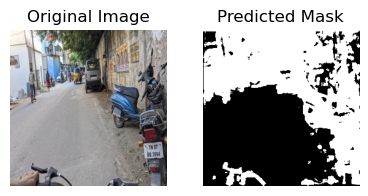

982 ms


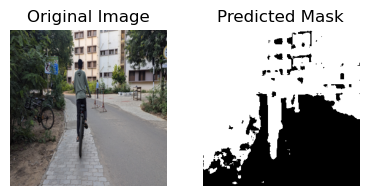

872 ms


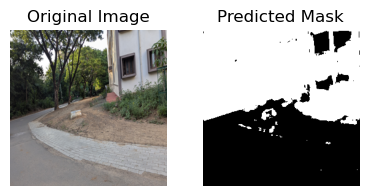

819 ms


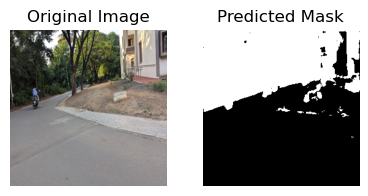

827 ms


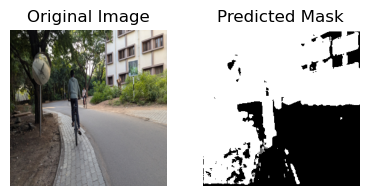

771 ms


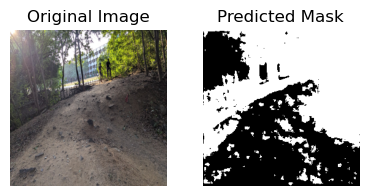

885 ms


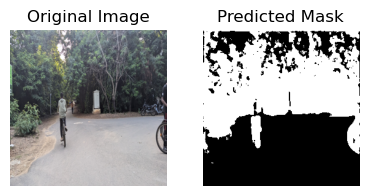

757 ms


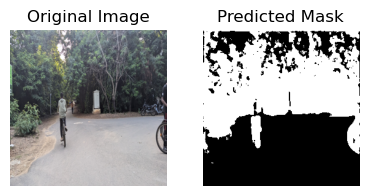

836 ms


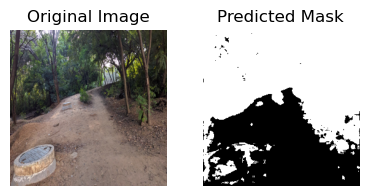

882 ms


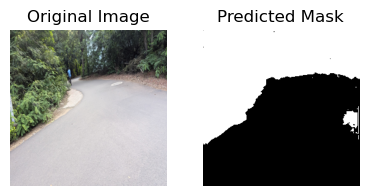

813 ms


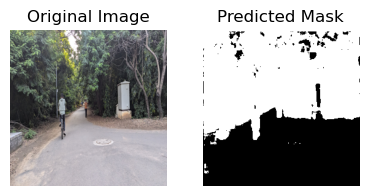

831 ms


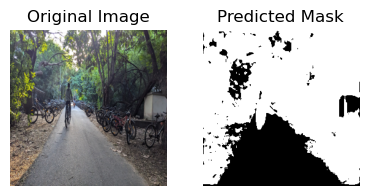

829 ms


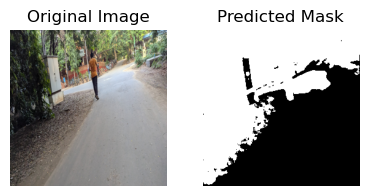

839 ms


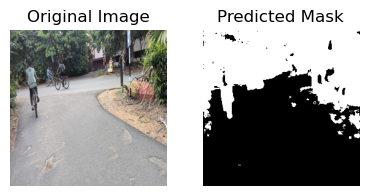

836 ms


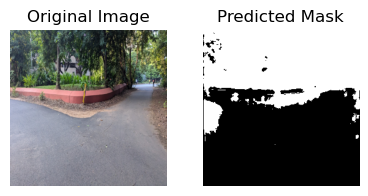

834 ms


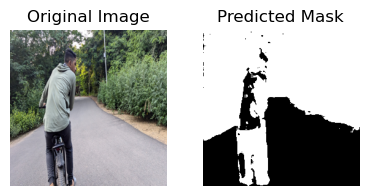

920 ms


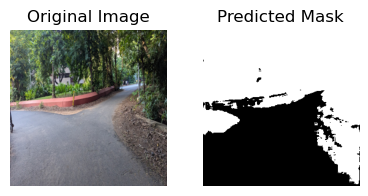

921 ms


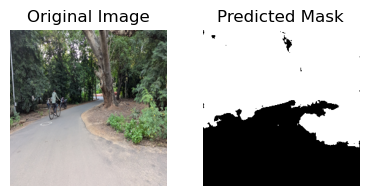

915 ms


In [45]:
import glob
import time
r"D:\Sahaay\obstacle_detection\indian_roads_archive\Indian_road_data\Indian_road_data\Raw_images\train\1_005\*.jpg"
r'D:\Sahaay\obstacle_detection\City_dataset_full-20240728T123354Z-001\City_dataset_full\City_2\images\*'
"D:\Sahaay\obstacle_detection\custom_images_img_seg\images1"
i = 0
for path in glob.glob(r'D:\Sahaay\obstacle_detection\custom_images_img_seg\images1\*'):
    t1 = time.time()
    msk = custom_image_test(path)
    t2 = time.time()
    
    print(int(1000*(t2-t1)),"ms")

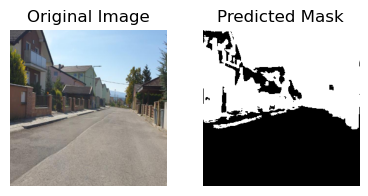

array([[0, 0, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [46]:
image_path = r"D:\Sahaay\obstacle_detection\City_dataset_full-20240728T123354Z-001\City_dataset_full\City_2\images\20201217_075239.jpg"
custom_image_test(image_path)

saving output images

In [47]:
# import glob
# import time
# import cv2 as cv
# r"D:\Sahaay\obstacle_detection\indian_roads_archive\Indian_road_data\Indian_road_data\Raw_images\train\1_005\*.jpg"
# r"D:\Sahaay\obstacle_detection\indian_roads_archive\Indian_road_data\Indian_road_data\Raw_images\train\1_005\*.jpg"
# glob.glob(r'D:\Sahaay\obstacle_detection\City_dataset_full-20240728T123354Z-001\City_dataset_full\City_2\images\*')[:10]
# os.makedirs(output_dir, exist_ok=True)

# i = 0
# output_dir = r'D:\Sahaay\obstacle_detection\road diversion images\output_masks'
# for path in glob.glob(r'D:\Sahaay\obstacle_detection\road diversion images\road diversion images\*'):
#     try:
#         t1 = time.time()
#         msk = custom_image_test(path)
#         output_path = os.path.join(output_dir, f'output_mask_{i}.png')
#         plt.imsave(output_path, msk, cmap='gray')
        
#         t2 = time.time()
#         print(f"Processed {path} in {int(1000 * (t2 - t1))} ms")
#         i += 1
#     except Exception as e:
#         print(f"Error processing {path}: {e}")